# Examining the MPI-Leipzig Mind-Brain-Body Dataset

The MRI data are available at https://openfmri.org/dataset/ds000221/. The behavioral data are available via NITRC: https://www.nitrc.org/projects/mpilmbb/. Note I was required to edit one file in the NITRC data (phenotype/BDI.json); it was missing a few `"` marks required to be valid json format.

### Behavoiral Data available

Each `.json` file describes the headers of the correspondingly name `.tsv` file. 

In [1]:
%%bash
ls MPI-Leipzig/behavioral_data_MPILMBB/phenotype | head

ACS.json
ACS.tsv
AMAS.json
AMAS.tsv
ASR.json
ASR.tsv
AUT.json
AUT.tsv
BCQ.json
BCQ.tsv


We can investigate what keys are available in any `.tsv` header by examining the corresponding `.json` file:

In [2]:
%%bash

cat MPI-Leipzig/behavioral_data_MPILMBB/phenotype/BDI.json | head

{
    "MeasurementToolMetadata": {
        "Description": "Beck's Depression Inventory II",
        "TermURL": ""
    },
    "BDI_sum_1": {
      "Description": "BDI Item 1",
      "Derivative": true
    },
    "BDI_sum_2": {


And we can investigate what values are associated with those behavioral keys by examining the `.tsv` files

In [13]:
%%bash

head MPI-Leipzig/behavioral_data_MPILMBB/phenotype/BDI.tsv

participant_id	BDI_sum_1	BDI_sum_2	BDI_sum_3	BDI_sum_4	BDI_sum_5	BDI_sum_6	BDI_sum_7	BDI_sum_8	BDI_sum_9	BDI_sum_10	BDI_sum_11	BDI_sum_12	BDI_sum_13	BDI_sum_14	BDI_sum_15	BDI_sum_16	BDI_sum_17	BDI_sum_18	BDI_sum_19	BDI_sum_20	BDI_sum_21	BDI_summary_sum
sub-010001	0.0	0.0	0.0	0.0	1.0	0.0	0.0	3.0	0.0	3.0	1.0	0.0	0.0	2.0	0.0	1.0	1.0	0.0	0.0	1.0	3.0	16.0
sub-010002	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	1.0	2.0
sub-010004	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	2.0	1.0	0.0	0.0	0.0	1.0	5.0
sub-010005	0.0	0.0	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	1.0	1.0	0.0	0.0	0.0	0.0	5.0
sub-010006	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	2.0
sub-010007	1.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	2.0	0.0	0.0	1.0	0.0	0.0	1.0	0.0	2.0	9.0
sub-010008	0.0	0.0	0.0	0.0	1.0	0.0	1.0	0.0	0.0	0.0	1.0	1.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	5.0
sub-010009	0.0	0.0	0.0	0.0	0.0	1.0	1.0	0.0	0.0	0.0	0.

### Investigating the range of data available

Provided in this repository is the script `find_subjects_behavior_data.py` which takes as arguments a list of `.tsv` files and a list of corresponding behavior keys to examine for each file. It pulls out the data associated with the behavior key given (ex: `NEO_N`) for each subject in the corresponding `.tsv` file. It provides the function `get_data`, which returns:
 - `subjects`: a dictionary with the subject names as keys. The values are themselves dictionaries keyed by behavior key name. For example:
 ```
 subjects['sub-000021'] = {
                             'BDI_summary_sum':1.0,
                             'HADS-D_summary_sum':2.0,
                             'NEO_N':63.0
                          }
 ```
 Note the sub-dictionary values will always be floats. If the behavior test was not recorded for that subject, the behavior key will not be present in that subject's dictionary.
 - `complete_subjects`: a dictionary structured as `subjects`. Only includes subjects that have values for all behavior keys given.
 - `raw_data`: a dictionary keyed by behavior name. The value is a list of floats corresponding to all the entries in the `.tsv` file for that behavior key.
 - `complete_raw_data`: a dictionary keyed by behavior name. The value is a list of floats corresponding to the entries in the `.tsv` file for that behavior key that also have values for all other behavior keys. Note each behavior key's value will always be a subset of the behavior key's value in `raw_data`

When run at the command-line, `find_subjects_behavior_data.py` will produce a set of box plots. Each box extends from the lower to upper quartile values of the data, with a line at the median. The whiskers extend from the box to show the range of the data. Flier points are those past the end of the whiskers. A dotted green line indicates the mean. The first column of box plots plot all available data for a given behavior key. The second column of box plots plot the data for a given behavior key such that the subjects who provide that data also have data for _every_ behavior key (taken from `complete_raw_data`). A row exists for each behavior key.

169 subjects have data in all given files


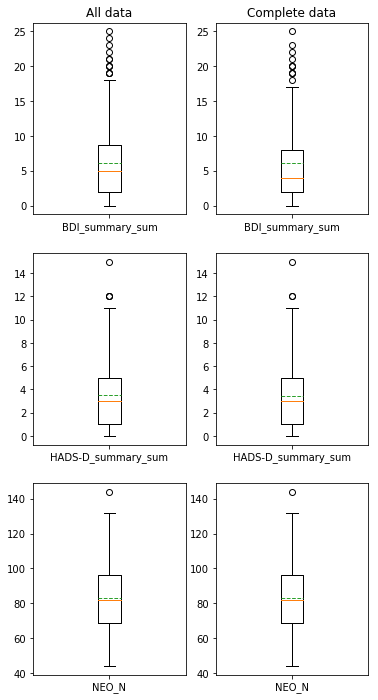

In [1]:
#Allow us to import python files in scripts
import sys
sys.path.append('./scripts')

import matplotlib.pyplot as plt
import numpy as np

import find_subjects_behavior_data as fsbd

#Arguments that would normally be passed through the command line call
behavior_files = [
    "MPI-Leipzig/behavioral_data_MPILMBB/phenotype/BDI.tsv",
    "MPI-Leipzig/behavioral_data_MPILMBB/phenotype/HADS.tsv",
    "MPI-Leipzig/behavioral_data_MPILMBB/phenotype/NEO.tsv"
]
behavior_keys = [
    "BDI_summary_sum",
    "HADS-D_summary_sum",
    "NEO_N"
]

#Get data using find_subject_data
subjects, complete_subjects, raw_data, complete_raw_data = fsbd.get_data(behavior_files, behavior_keys)

fsbd.draw_figure(behavior_keys, raw_data, complete_raw_data)
plt.show()


Now we have an easy way to see the range of the behavioral data available. A non-static version of the above code is below.

### MRI data available

If you'd like to interactively work with find_subjects_data, a non-static version of the code is below:

In [2]:
%matplotlib notebook

#Allow us to import python files in scripts
import sys
sys.path.append('./scripts')

import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interactive 

import find_subjects_behavior_data as fsbd

#Arguments that would normally be passed through the command line call
behavior_files = [
    "MPI-Leipzig/behavioral_data_MPILMBB/phenotype/BDI.tsv",
    "MPI-Leipzig/behavioral_data_MPILMBB/phenotype/HADS.tsv",
    "MPI-Leipzig/behavioral_data_MPILMBB/phenotype/NEO.tsv"
]
behavior_keys = [
    "BDI_summary_sum",
    "HADS-D_summary_sum",
    "NEO_N"
]

#Get data using find_subject_data
subjects, complete_subjects, raw_data, complete_raw_data = fsbd.get_data(behavior_files, behavior_keys)

def draw_figure():
    fsbd.draw_figure(behavior_keys, raw_data, complete_raw_data)
    
interactive_plot = interactive(draw_figure)
interactive_plot


169 subjects have data in all given files
